<a href="https://colab.research.google.com/github/eshal26/Handwritten-Multi-Digit-Classification/blob/main/Digit_Classification_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import gdown

# Google Drive file ID
file_id = '1xqyW289seXYaDSqD2jaBPMKVAAjPP9ee'
destination = '/content/dataset.zip'

# Download the dataset
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1xqyW289seXYaDSqD2jaBPMKVAAjPP9ee
From (redirected): https://drive.google.com/uc?id=1xqyW289seXYaDSqD2jaBPMKVAAjPP9ee&confirm=t&uuid=8dab9fa4-1454-4fb1-b0f8-e28c5e1ac137
To: /content/dataset.zip
100%|██████████| 926M/926M [00:05<00:00, 169MB/s]


'/content/dataset.zip'

In [3]:
!unzip dataset.zip

Streaming output truncated to the last 5000 lines.
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/856_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/638_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/736_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/507_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/578_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/620_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/920_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/699_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/599_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/874_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/760_953.png  
 extracting: triple_mnist_seed_123_image_size_84_84/train/953/171_953.png  
 extracting: triple_mnist_seed_123_im

<h1>Handwritten Multi-Digit Classification</h1>

<h2>Data Preprocessing</h2>

In [27]:
import numpy as np
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(84),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.1307], std=[0.3081])  # Normalize with 1-channel mean and std


])

In [28]:
from torchvision import datasets
train_dir = 'triple_mnist_seed_123_image_size_84_84/train'
test_dir = 'triple_mnist_seed_123_image_size_84_84/test'
val_dir = 'triple_mnist_seed_123_image_size_84_84/val'

train_dataset = datasets.ImageFolder(root = train_dir , transform = transform)
test_dataset = datasets.ImageFolder(root = test_dir , transform = transform)
val_dataset = datasets.ImageFolder(root = val_dir , transform = transform)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, num_workers = 4)
test_dataloader = DataLoader(test_dataset, batch_size = 64, shuffle = False, num_workers = 4)
val_dataloader = DataLoader(val_dataset, batch_size = 64, shuffle = False, num_workers = 4)

print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")


Number of training images: 640000
Number of testing images: 200000
Number of validation images: 160000


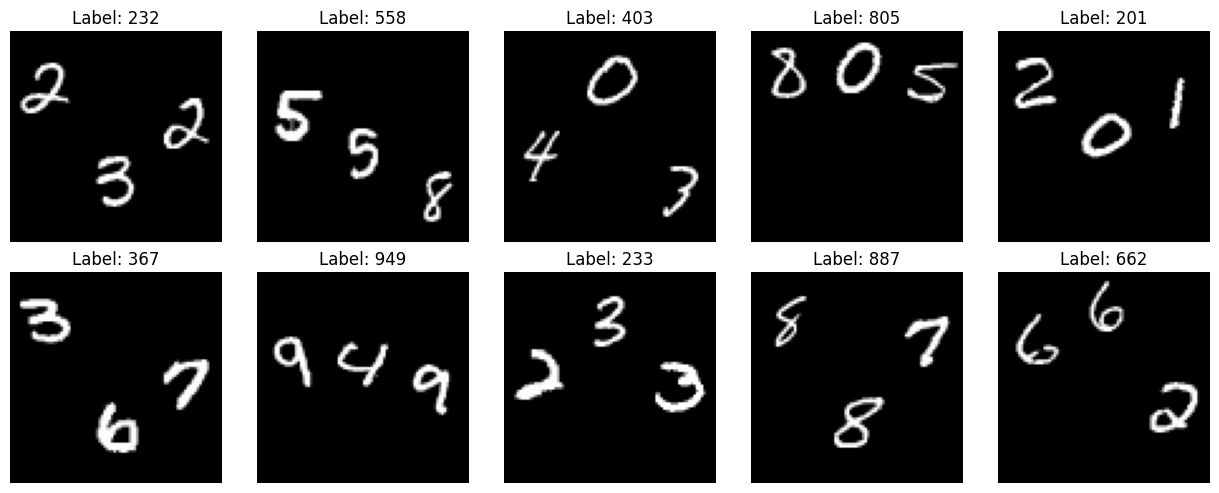

In [12]:
import matplotlib.pyplot as plt

def show_images(images, labels, class_names, num_images_to_display=10):
    # Select a subset of images and labels to display
    images = images[:num_images_to_display]
    labels = labels[:num_images_to_display]

    # Calculate the number of rows and columns
    cols = min(num_images_to_display, 5)
    rows = (num_images_to_display + cols - 1) // cols

    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    for i in range(len(images)):
        plt.subplot(rows, cols, i + 1)
        image = images[i].numpy().transpose((1, 2, 0))  # Convert from Tensor image to NumPy image
        mean = [0.1307]
        std = [0.3081]
        image = std * image + mean  # Denormalize
        image = image.clip(0, 1)
        plt.imshow(image.squeeze(), cmap='gray')
        plt.title(f'Label: {class_names[labels[i]]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()


class_names = train_dataset.classes

# Load a batch of images and labels
images, labels = next(iter(train_dataloader))

# Show the images and labels
show_images(images, labels, class_names)


<h2>Loading Pre-trained Model</h2>

In [7]:
import torchvision.models as models

# Define MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Modify the first convolution layer to accept 1-channel images
mobilenet_v2.features[0][0] = torch.nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)

# Modify the classifier for multi-digit classification
num_classes = 1000  # 10^3 for 3-digit classification
in_features = mobilenet_v2.classifier[1].in_features
mobilenet_v2.classifier = torch.nn.Sequential(
    torch.nn.Linear(in_features, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    torch.nn.Linear(512, num_classes)
)

# Move model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenet_v2.to(device)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 94.8MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

<h2>Training Loop</h2>

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2.parameters(), lr=0.001)

# Define the learning rate scheduler
scheduler = StepLR(optimizer, step_size=2, gamma=0.5)  # Decrease LR by a factor of 0.5 every 2 epochs

# Training function
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

# Evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            running_loss += loss.item()
    avg_loss = running_loss / len(dataloader)
    accuracy = correct / total
    return avg_loss, accuracy

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(10):
    # Train the model
    train_loss, train_accuracy = train(mobilenet_v2, train_dataloader, criterion, optimizer, device)

    # Evaluate the model
    val_loss, val_accuracy = evaluate(mobilenet_v2, val_dataloader, criterion, device)

    # Update the learning rate
    scheduler.step()

    # Append to lists for tracking
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    # Print training and validation results
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')


Epoch 1, Train Loss: 1.0110, Train Accuracy: 0.6398, Val Loss: 87.4506, Val Accuracy: 0.0000
Epoch 2, Train Loss: 0.5222, Train Accuracy: 0.8309, Val Loss: 100.5587, Val Accuracy: 0.0060
Epoch 3, Train Loss: 0.1984, Train Accuracy: 0.9433, Val Loss: 115.2228, Val Accuracy: 0.0063


<h2>Plotting Training and Validation Accuracies</h2>

<h2>Evaluating Model</h2>

<h2>Saving Trained Model to Deploy</h2>